# CS 497/597: Tensorflow With Mobilenet V2

## Purpose of the assignment:

To familiarize ourselves with Tensorflow and MobileNet V2 by training, tuning, and explaining how MobileNet V2 works by training it on both CIFAR100 and a dataset of our choosing. 

### Step 1: Data Preprocessing

In [2]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import logging

import numpy as np
import tensorflow.python.framework.ops as ops

In [3]:
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
# Import the training and test data for CIFAR100 and load 
# the fine grained class labels so we can use all 100 classes

(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [5]:
# Print the shape of the training and testing images and labels
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y_train[0])

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
9


Note: CIFAR100 contains 60,000 images total with 100 classes. Each image is size 32 x 32 with RGB values for a total of 32 x 32 x 3 size per image. This means that each image is somewhat small in size, with only 1024 pixels and 3072 values total including RGB pixel values. The dataset loaded here is split into 50K training images and 10K test images (80% training and 20% testing).

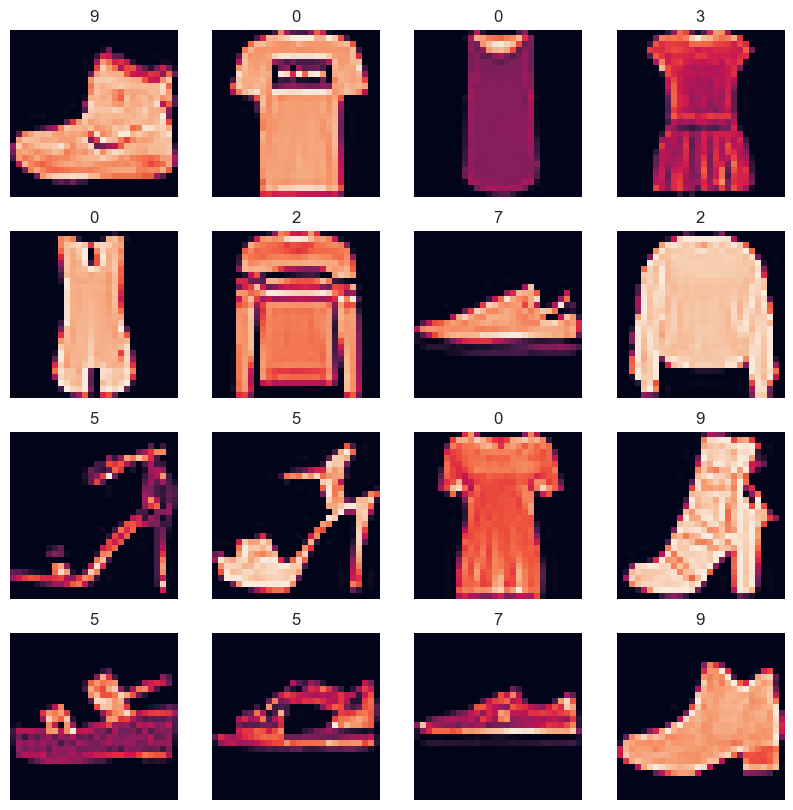

In [6]:
# Show 16 example images from the CIFAR100 dataset
plt.figure(figsize=(10,10))

for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(x_train[i])
    plt.title(y_train[i])
    plt.axis("off")

Looking at the first 16 images in the training dataset, it is clear that 1024 pixels doesn't leave room for a lot of detail. Most of the images are blurry with little space for even large patterns. The image at the bottom right appears to be a keyboard, but the image is so small that it is impossible to read what keys are displayed in the image. The image in the bottom left is an image with 3 sunflowers, but it is so pixelated that it is difficult to see how many flower petals each sunflower has. This lack of detail could either help a CNN focus on key features of an image or hurt a CNN by blurring important features that can help it distinguish between classes. We cannot know for sure whether this improves or harms MobileNet's performance until it is tested. 

Normalizing the data 0-255

In [7]:

x_train= tf.image.grayscale_to_rgb(tf.expand_dims(tf.convert_to_tensor(x_train), axis=3))
x_test= tf.image.grayscale_to_rgb(tf.expand_dims(tf.convert_to_tensor(x_test), axis=3))

# Upscale the Fashion-MNIST x_train and x_test images from 32 x 32 to 80 x 80
# to upscale features for MobileNet V2 (which was trained on images with 224 x 224 pixels from the ImageNet dataset) 
x_train= tf.cast(tf.image.resize(x_train, size=[64, 64], method=tf.image.ResizeMethod.BICUBIC),tf.float32)
                    
x_test = tf.cast(tf.image.resize(x_test, size=[64, 64], method=tf.image.ResizeMethod.BICUBIC),tf.float32)
                         
print(x_train.shape)
print(x_test.shape)
x_test = x_test / 255.0
x_train = x_train / 255.0

print(x_train.shape)
print(x_test.shape)

# y_test = keras.utils.to_categorical(y_test, 10)
# y_train = keras.utils.to_categorical(y_train, 10)
 

(60000, 64, 64, 3)
(10000, 64, 64, 3)
(60000, 64, 64, 3)
(10000, 64, 64, 3)


### Step 2: Model Construction

In [8]:

# Construct a model built on top of MobileNetV2 with an
# input layer that takes in an image of the dimensions specified
# in x_data, sends said image into mobilenet, and then takes the
# output from mobilenet into a simple classifiation head that 
# predicts what label said image is from a range of labels.
# This function will return the constructed (but not compiled)
# mobilenet V2 model
model = keras.models.Sequential()


    # Prepare base MobileNet V2 model
    # global base_mobilenet
base_mobilenet = tf.keras.applications.MobileNetV2(input_shape=(64,64,3),include_top=False, weights="imagenet")
base_mobilenet.trainable = False

# Create an input layer for the image itself
model.add(base_mobilenet)



C:\Users\pniko\AppData\Local\Temp\ipykernel_8452\2258525612.py:13: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_mobilenet = tf.keras.applications.MobileNetV2(input_shape=(64,64,3),include_top=False, weights="imagenet")


In [9]:
#3 Show the fully constructed model's parameter count and memory footprint including the base MobileNet V2 model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
# Get the prediction size of the data
model.add(keras.layers.Flatten())

# Create an intermediate dense layer between the average pooling layer and final prediction layer
hidden_output_layer = keras.layers.Dense(1280, activation='relu')

# Create a prediction layer for each class in the fashion-mnist dataset
prediction_layer = keras.layers.Dense(10, activation='softmax')

model.add(hidden_output_layer)

model.add(prediction_layer)


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1280)           │     6,554,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,825,674 (33.67 MB)

 Trainable params: 6,567,690 (25.05 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Step 3: Train Extended MobileNetV2 Model on CIFAR100 Dataset

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10,validation_data=(x_test, y_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 77s 40ms/step - accuracy: 0.7992 - loss: 0.6744 - val_accuracy: 0.8422 - val_loss: 0.4233
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 74s 40ms/step - accuracy: 0.8720 - loss: 0.3503 - val_accuracy: 0.8579 - val_loss: 0.4090
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 75s 40ms/step - accuracy: 0.8957 - loss: 0.2872 - val_accuracy: 0.8531 - val_loss: 0.4234
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 75s 40ms/step - accuracy: 0.9117 - loss: 0.2382 - val_accuracy: 0.8673 - val_loss: 0.4084
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 75s 40ms/step - accuracy: 0.9266 - loss: 0.1994 - val_accuracy: 0.8529 - val_loss: 0.5012
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 78s 41ms/step - accuracy: 0.9379 - loss: 0.1675 - val_accuracy: 0.8619 - val_loss: 0.5640
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 78s 41ms/step - accuracy: 0.9458 - loss: 0.1434 - val_accuracy: 0.8600 - val_loss: 0.5590
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 79s 42ms/step - accuracy: 0.9574 -

313/313 - 6s - 19ms/step - accuracy: 0.8636 - loss: 0.6996
0.8636000156402588


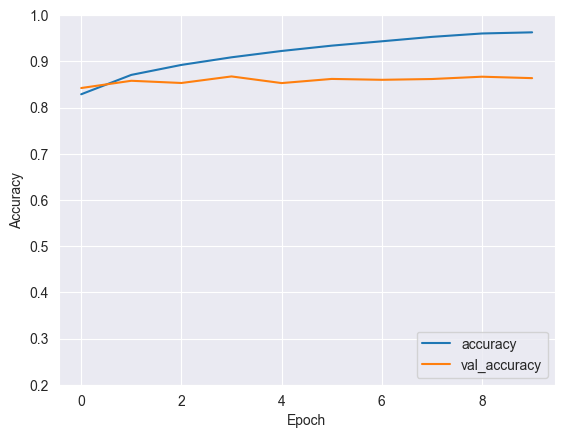

In [12]:
#evaluate the model
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(test_acc)
# # Plot the validation and training accuracy and loss of MobileNetV2 across all training epochs
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# 
# # Extract all of the metric history for plotting and add fine tuning history if it exists
# if fine_tune_history is not None:
#     acc += fine_tune_history.history["accuracy"]
#     val_acc += fine_tune_history.history['val_accuracy']
# 
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# 
# if fine_tune_history is not None:
#     loss += fine_tune_history.history["loss"]
#     val_loss += fine_tune_history.history['val_loss']
# 
# precision = history.history['precision']
# val_precision = history.history['val_precision']
# 
# if fine_tune_history is not None:
#     precision += fine_tune_history.history["precision"]
#     val_precision += fine_tune_history.history['val_precision']
# 
# recall = history.history['recall']
# val_recall = history.history['val_recall']
# 
# if fine_tune_history is not None:
#     recall += fine_tune_history.history["recall"]
#     val_recall += fine_tune_history.history['val_recall']
# 
# f1_score = history.history['f1_score']
# val_f1_score = history.history['val_f1_score']
# 
# if fine_tune_history is not None:
#     f1_score += fine_tune_history.history["f1_score"]
#     val_f1_score += fine_tune_history.history['val_f1_score']
# 
# # Plot the training and validation accuracies for CIFAR100
# fig, ax = plt.subplots(nrows=5, ncols=1)
# fig.set_figwidth(10)
# fig.set_figheight(25)
# #plt.subplot(1, 1, 1)
# plt.xticks(range(0, total_epochs, 1))
# plt.ylim((0,1))
# 
# ax[0].plot(acc, label='Training Accuracy')
# ax[0].plot(val_acc, label='Validation Accuracy')
# if fine_tune_history is not None:
#     ax[0].plot([initial_epochs-1, initial_epochs-1], 
#                plt.ylim(), label='Start Fine Tuning')
# ax[0].legend(loc='lower right')
# ax[0].set_ylabel('Accuracy')
# ax[0].set_ylim([min(plt.ylim()),1])
# ax[0].set_xlabel('epoch')
# ax[0].set_title('Training and Validation Accuracy For MobileNet V2 on CIFAR100 Dataset')
# 
# #Plot the training and validation losses for CIFAR100
# #plt.subplot(2, 1, 2)
# ax[1].plot(loss, label='Training Loss')
# ax[1].plot(val_loss, label='Validation Loss')
# if fine_tune_history is not None:
#     ax[1].plot([initial_epochs-1, initial_epochs-1], 
#                 ax[1].get_ylim(), label='Start Fine Tuning')
# ax[1].legend(loc='upper right')
# ax[1].set_ylabel('Cross Entropy')
# ax[1].set_title('Training and Validation Loss')
# ax[1].set_xlabel('epoch')
# ax[1].set_xticks(range(0, total_epochs, 1))
# 
# #Plot the training and validation precision for CIFAR100
# #plt.subplot(1, 2, 1)
# ax[2].plot(precision, label='Training Precision')
# ax[2].plot(val_precision, label='Validation Precision')
# if fine_tune_history is not None:
#     ax[2].plot([initial_epochs-1, initial_epochs-1], 
#                 plt.ylim(), label='Start Fine Tuning')
# ax[2].legend(loc='upper right')
# ax[2].set_ylabel('Precision')
# ax[2].set_title('Training and Validation Precision')
# ax[2].set_xlabel('epoch')
# ax[2].set_xticks(range(0, total_epochs, 1))
# 
# #Plot the training and validation recall for CIFAR100
# ax[3].plot(recall, label='Training Recall')
# ax[3].plot(val_recall, label='Validation Recall')
# if fine_tune_history is not None:
#     ax[3].plot([initial_epochs-1, initial_epochs-1], 
#                 plt.ylim(), label='Start Fine Tuning')
# ax[3].legend(loc='upper right')
# ax[3].set_ylabel('Recall')
# ax[3].set_title('Training and Validation Recall')
# ax[3].set_xlabel('epoch')
# ax[3].set_xticks(range(0, total_epochs, 1))
# 
# #Plot the training and validation f1 score for CIFAR100
# ax[4].plot(f1_score, label='Training F1 Score')
# ax[4].plot(val_f1_score, label='Validation F1 Score')
# if fine_tune_history is not None:
#     ax[4].plot([initial_epochs-1, initial_epochs-1], 
#                 plt.ylim(), label='Start Fine Tuning')
# ax[4].legend(loc='upper right')
# ax[4].set_ylabel('F1 Score')
# ax[4].set_title('Training and Validation F1 Score')
# ax[4].set_xlabel('epoch')
# ax[4].set_xticks(range(0, total_epochs, 1))

# Show both the training and validation accuracies
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step


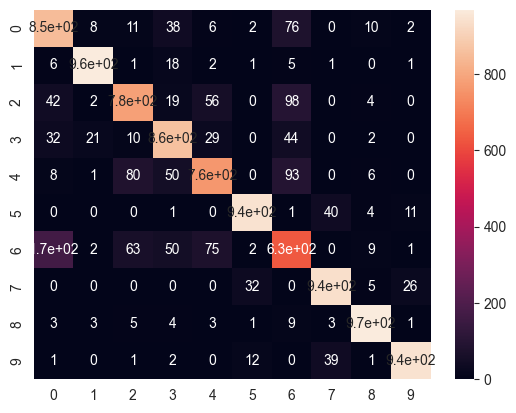

              precision    recall  f1-score   support

           0       0.76      0.85      0.80      1000
           1       0.96      0.96      0.96      1000
           2       0.82      0.78      0.80      1000
           3       0.83      0.86      0.84      1000
           4       0.82      0.76      0.79      1000
           5       0.95      0.94      0.95      1000
           6       0.66      0.63      0.64      1000
           7       0.92      0.94      0.93      1000
           8       0.96      0.97      0.96      1000
           9       0.96      0.94      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [13]:
#importing necessary libraries for model evaluation and graphical
import sklearn
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_pred = np.argmax(model.predict(x_test), axis=-1) #generating class predictions
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()
print(classification_report(y_test, y_pred))